# This Notebook will be Utilized for CapStone Project

## IBM Data Science Course 9

# Week 1

Creating the Repository

# Week 2

### Introduction/Business Problem:

The aim of the project is to create a model which will be able to predict the 
Possibility and Severity of an accident depending upon Weather Conditions, 
Road Conditions and other relevant attributes so that you can drive more carefully.

### Data Description:

The dataset being used is the one which is available in the capstone project. No external dataset has been used.

Dataset contains records of all types of collisions recorded in Traffic records and shared by SDOT Traffic Management Division. Timeframe : 2004 to Present

We will be performing extensive Exploratory Data Analysis and understand the variables distribution. Many of the attributes available are post facto and are for record keeping, which will be removed.

We will be selecting the variables having information pertaining to cause of accidents and severity.

There are a total of 194673 rows and 38 columns in the data.

Target Variable : SEVERITYCODE

# Week 3 WIP

### Importing Libraries and Creating Useful Fucntions

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [3]:
#get iqr
def iqr(x):
    return x.quantile(q=0.75)-x.quantile(q=0.25)

#get outliars x>75% quantile+1.5*IQR + x<25% quantile-1.5*IQR
def outlier_cnt(x):
    upper_cnt = x.quantile(q=0.75)+ 1.5*iqr(x)
    lower_cnt = x.quantile(q=0.25)- 1.5*iqr(x)
    return len(x[x>upper_cnt]) + len(x[x<lower_cnt])

def remove_outlier(x):
    upper_cnt = x.quantile(q=0.75) + 1.5*iqr
    lower_cnt = x.quantile(q=0.25) - 1.5*iqr
    return x[(x<=upper_cnt) & (x>=lower_cnt)]

In [4]:
#function to get dataframe information
def data_information(x,todrop):
    x1 = x.drop(todrop, axis=1)
    
    dict={}
    dict['Number of Observation']= len(x1)
    dict['Number of Variables']= len(x1.columns)
    dict['Number of Numeric Variables']= len(x1.select_dtypes(include='number').columns)
    dict['Number of Factor Variables']= len(x1.select_dtypes(include='category').columns)
    dict['Number of Categorical Variables']= len(x1.select_dtypes(include='object').columns)
    dict['Number of Date Variables']= len(x1.select_dtypes(include='datetime64').columns)
    dict['Number of Logical Variables']= len(x1.select_dtypes(include='bool').columns)
    #dict['Number of Zero Variance Variables']= 
    null_pct = pd.DataFrame(x1.isnull().sum()/x1.shape[0])
    null_pct.columns = ['null_pct']
    
    dict['Num of Variables having complete cases']= null_pct[null_pct.null_pct==0].shape[0]
    dict['Num of Variables with <=50Pct missing cases']= null_pct[null_pct.null_pct<=0.5].shape[0]
    dict['Num of Variables with >50Pct missing cases']= null_pct[null_pct.null_pct>0.5].shape[0]
    dict['Num of Variables with >90Pct missing cases']= null_pct[null_pct.null_pct>0.9].shape[0]

    dict['Pct of Variables having complete cases']= null_pct[null_pct.null_pct==0].shape[0]*100/x1.shape[1]
    dict['Pct of Variables with <=50Pct missing cases']= null_pct[null_pct.null_pct<=0.5].shape[0]*100/x1.shape[1]
    dict['Pct of Variables with >50Pct missing cases']= null_pct[null_pct.null_pct>0.5].shape[0]*100/x1.shape[1]
    dict['Pct of Variables with >90Pct missing cases']= null_pct[null_pct.null_pct>0.9].shape[0]*100/x1.shape[1]
    
    data_info = pd.DataFrame(dict, index=['Values'])
    return data_info.T.round(2)

In [5]:
#function for numerical analysis

def num_univariate(x,todrop):
    x1 = x.drop(todrop, axis=1)
    
    x1 = x1.select_dtypes(include='number')
    data_num_info = pd.DataFrame()
    
    for i in x1.columns:
        data_num_info.loc[i,'Negative Value Count']=x1[x1[i]<0].shape[0]
        data_num_info.loc[i,'Positive Value Count']=x1[x1[i]>0].shape[0]
        data_num_info.loc[i,'Zeros Count']=x1[x1[i]==0].shape[0]
        data_num_info.loc[i,'Unique Count']=x1[i].unique().shape[0]
        data_num_info.loc[i,'Missing Percent']=x1[i].isnull().sum()*100/x1.shape[0]
        data_num_info.loc[i,'Count of Outliers']=outlier_cnt(x1[i])
    return data_num_info.round(2)

In [6]:
#function for categorical analysis

def cat_univariate(x,todrop):
    x1 = x.drop(columns=todrop)
    
    x1 = x1.select_dtypes(include=['object','bool','category'])
    data_cat_info = pd.DataFrame()
    try: #incase any categorical variable is not present
        for i in x1.columns:
            data_cat_info.loc[i,'Unique Categories'] = x1[i].unique().shape[0]
            data_cat_info.loc[i,'Missing Percent'] = x1[i].isnull().sum()*100/x1.shape[0]
    except:
        pass
    return data_cat_info.round(2)

In [7]:
#function for Statistical analysis

def stats_data(x,todrop):
    x1 = x.drop(todrop, axis=1)
    
    x1 = x1.select_dtypes(include='number')
    data_stat_info = pd.DataFrame()
    data_stat_info = x1.describe().T
    
    for i in x1.columns:
        data_stat_info.loc[i,'10%'] = x1[i].quantile(q=0.1)
        data_stat_info.loc[i,'90%'] = x1[i].quantile(q=0.9)
        data_stat_info.loc[i,'99%'] = x1[i].quantile(q=0.99)
        data_stat_info.loc[i,'outlier_count'] = outlier_cnt(x1[i])
        
    
    return data_stat_info.round(2)

In [8]:
#function for numerical data exploration

def num_check(x, todrop, group):
    x1 = x.drop(columns=todrop)
    
    x1 = x1.select_dtypes(include='number')
    
    for g in group:
        summary = pd.DataFrame()
        for i in x1.columns:
            sub_summary = x1.groupby(g)[i].describe().reset_index()
            sub_summary['Variable'] = i
            summary = sub_summary.append(summary)
        summary = summary.set_index(['Variable',g])
    return summary.round(2)

In [9]:
#create classes to data visualization

class plotting(object):
    def __init__(self,x):
        self.x = x
        
    def num_plt(self):
        bins = max(round(self.x.nunique()/100),min(round(self.x.nunique()),10))
        plt1 = sns.distplot(self.x,hist=True,kde=True,bins=bins,color='C4',rug=False)
        plt.xticks(rotation=45)
        
    def wo_outlier_num_plt(self):
        self.x= remove_outlier(self.x)
        bins = max(round(self.x.nunique()/100),min(round(self.x.nunique()),10))
        plt2 = sns.distplot(self.x,hist=True,kde=True,bins=bins,color='C2',rug=False)
        plt.xticks(rotation=45)
        
    def cat_plt(self):
        plt.hist(self.x)
        plt.xticks(rotation=90)
        
    def distrib_plt(self):
        if self.x.dtypes == 'bool' or self.x.dtypes=='object':
            self.cat_plt()
        else:
            self.num_plt()
    
    def wo_outlier_distrib_plt(self):
        if self.x.dtypes == 'bool' or self.x.dtypes=='object':
            self.cat_plt()
        else:
            self.wo_outlier_num_plt()
            
class plotted(object):
    def __init__(self,x, todrop):
        self.x=x
        self.todrop=todrop
        
    def density_plt(self):
        d = self.x.drop(columns=self.todrop)
        
        for i in d.columns:
            plotting(d[d[i].notnull()][i]).distrib_plt()
            plt.xlabel(i)
            plt.ylabel('Count')
            plt.show()
            
    def wo_outlier_density_plt(self):
        d = self.x.drop(columns=self.todrop)
        
        for i in d.columns:
            plotting(d[d[i].notnull()][i]).wo_outlier_distrib_plt()
            plt.xlabel(i)
            plt.ylabel('Count')
            plt.show()
            
    def box_plt(self):
        d = self.x.drop(columns=self.todrop)
        d = self.x.select_dtypes(include='number')
        
        for i in d.columns:
            sns.boxplot(d[d[i].notnull()][i],orient='v')
            plt.xlabel(i)
            plt.ylabel('Value')
            plt.show()
            
    def wo_outlier_box_plt(self):
        d = self.x.drop(columns=self.todrop)
        d = self.x.select_dtypes(include='number')
        
        for i in d.columns:
            sns.boxplot(remove_outlier(d[d[i].notnull()][i]),orient='v')
            plt.xlabel(i)
            plt.ylabel('Value')
            plt.show()

###Get the data

In [10]:
#Unizipping the data from google drive 
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Data-Collisions.csv.zip", 'r')
zip_ref.extractall("/content/drive/My Drive/Unzippeddata")
zip_ref.close()

#data_path = r"/Users/rahulsharma/Downloads/Data-Collisions.csv";
#df = pd.read_csv(data_path)
#df.tail()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [130]:
#reading the data from drive
df = pd.read_csv(r"/content/drive/My Drive/Unzippeddata/Data-Collisions.csv", low_memory=False)
df.tail()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
194668,2,-122.290826,47.565408,219543,309534,310814,E871089,Matched,Block,NaN,34TH AVE S BETWEEN S DAKOTA ST AND S GENESEE ST,,NaN,2,Injury Collision,Head On,3,0,0,2,2018/11/12 00:00:00+00,11/12/2018 8:12:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,24,From opposite direction - both moving - head-on,0,0,N
194669,1,-122.344526,47.690924,219544,309085,310365,E876731,Matched,Block,NaN,AURORA AVE N BETWEEN N 85TH ST AND N 86TH ST,,NaN,1,Property Damage Only Collision,Rear Ended,2,0,0,2,2018/12/18 00:00:00+00,12/18/2018 9:14:00 AM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",Y,N,Raining,Wet,Daylight,NaN,NaN,NaN,13,From same direction - both going straight - bo...,0,0,N
194670,2,-122.306689,47.683047,219545,311280,312640,3809984,Matched,Intersection,24760.0,20TH AVE NE AND NE 75TH ST,,NaN,2,Injury Collision,Left Turn,3,0,0,2,2019/01/19 00:00:00+00,1/19/2019 9:25:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,28,From opposite direction - one left turn - one ...,0,0,N
194671,2,-122.355317,47.678734,219546,309514,310794,3810083,Matched,Intersection,24349.0,GREENWOOD AVE N AND N 68TH ST,,NaN,2,Injury Collision,Cycles,2,0,1,1,2019/01/15 00:00:00+00,1/15/2019 4:48:00 PM,At Intersection (intersection related),51,PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT...,NaN,N,Clear,Dry,Dusk,NaN,NaN,NaN,5,Vehicle Strikes Pedalcyclist,4308,0,N
194672,1,-122.289360,47.611017,219547,308220,309500,E868008,Matched,Block,NaN,34TH AVE BETWEEN E MARION ST AND E SPRING ST,,NaN,1,Property Damage Only Collision,Rear Ended,2,0,0,2,2018/11/30 00:00:00+00,11/30/2018 3:45:00 PM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Clear,Wet,Daylight,NaN,NaN,NaN,14,From same direction - both going straight - on...,0,0,N


In [12]:
df.shape

(194673, 38)

In [13]:
#getting column list
df.columns.tolist()

['SEVERITYCODE',
 'X',
 'Y',
 'OBJECTID',
 'INCKEY',
 'COLDETKEY',
 'REPORTNO',
 'STATUS',
 'ADDRTYPE',
 'INTKEY',
 'LOCATION',
 'EXCEPTRSNCODE',
 'EXCEPTRSNDESC',
 'SEVERITYCODE.1',
 'SEVERITYDESC',
 'COLLISIONTYPE',
 'PERSONCOUNT',
 'PEDCOUNT',
 'PEDCYLCOUNT',
 'VEHCOUNT',
 'INCDATE',
 'INCDTTM',
 'JUNCTIONTYPE',
 'SDOT_COLCODE',
 'SDOT_COLDESC',
 'INATTENTIONIND',
 'UNDERINFL',
 'WEATHER',
 'ROADCOND',
 'LIGHTCOND',
 'PEDROWNOTGRNT',
 'SDOTCOLNUM',
 'SPEEDING',
 'ST_COLCODE',
 'ST_COLDESC',
 'SEGLANEKEY',
 'CROSSWALKKEY',
 'HITPARKEDCAR']

### Understanding Target Variable

In [14]:
df['SEVERITYCODE'].describe()

count    194673.000000
mean          1.298901
std           0.457778
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           2.000000
Name: SEVERITYCODE, dtype: float64

In [15]:
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

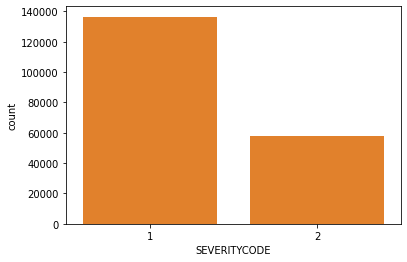

In [18]:
sns.countplot(df['SEVERITYCODE'], color='C1')

### Analyzing Attributes : Univariate Analysis

In [19]:
data_information(df,['SEVERITYCODE'])

,Values
Number of Observation,194673.00
Number of Variables,37.00
Number of Numeric Variables,15.00
Number of Factor Variables,0.00
Number of Categorical Variables,22.00
Number of Date Variables,0.00
Number of Logical Variables,0.00
Num of Variables having complete cases,18.00
Num of Variables with <=50Pct missing cases,31.00
Num of Variables with >50Pct missing cases,6.00


In [20]:
num_univariate(df,['SEVERITYCODE'])

,Negative Value Count,Positive Value Count,Zeros Count,Unique Count,Missing Percent,Count of Outliers
X,189339.0,0.0,0.0,23564.0,2.74,1560.0
Y,0.0,189339.0,0.0,23840.0,2.74,0.0
OBJECTID,0.0,194673.0,0.0,194673.0,0.00,0.0
INCKEY,0.0,194673.0,0.0,194673.0,0.00,0.0
COLDETKEY,0.0,194673.0,0.0,194673.0,0.00,0.0
INTKEY,0.0,65070.0,0.0,7615.0,66.57,1404.0
SEVERITYCODE.1,0.0,194673.0,0.0,2.0,0.00,0.0
PERSONCOUNT,0.0,189129.0,5544.0,47.0,0.00,17075.0
PEDCOUNT,0.0,6939.0,187734.0,7.0,0.00,6939.0
PEDCYLCOUNT,0.0,5484.0,189189.0,3.0,0.00,5484.0


In [21]:
cat_univariate(df,['SEVERITYCODE'])

,Unique Categories,Missing Percent
REPORTNO,194670.0,0.00
STATUS,2.0,0.00
ADDRTYPE,4.0,0.99
LOCATION,24103.0,1.38
EXCEPTRSNCODE,3.0,56.43
EXCEPTRSNDESC,2.0,97.10
SEVERITYDESC,2.0,0.00
COLLISIONTYPE,11.0,2.52
INCDATE,5985.0,0.00
INCDTTM,162058.0,0.00


In [22]:
stats_data(df,['SEVERITYCODE'])

,count,mean,std,min,25%,50%,75%,max,10%,90%,99%,outlier_count
X,189339.0,-122.33,0.03,-122.42,-122.35,-122.33,-122.31,-122.24,-122.37,-122.29,-122.27,1560.0
Y,189339.0,47.62,0.06,47.50,47.58,47.62,47.66,47.73,47.54,47.70,47.73,0.0
OBJECTID,194673.0,108479.36,62649.72,1.00,54267.00,106912.00,162272.00,219547.00,23695.40,196557.80,217258.28,0.0
INCKEY,194673.0,141091.46,86634.40,1001.00,70383.00,123363.00,203319.00,331454.00,39749.20,282298.80,328483.28,0.0
COLDETKEY,194673.0,141298.81,86986.54,1001.00,70383.00,123363.00,203459.00,332954.00,39749.20,283158.80,329983.28,0.0
INTKEY,65070.0,37558.45,51745.99,23807.00,28667.00,29973.00,33973.00,757580.00,25483.80,36525.00,351236.61,1404.0
SEVERITYCODE.1,194673.0,1.30,0.46,1.00,1.00,1.00,2.00,2.00,1.00,2.00,2.00,0.0
PERSONCOUNT,194673.0,2.44,1.35,0.00,2.00,2.00,3.00,81.00,2.00,4.00,7.00,17075.0
PEDCOUNT,194673.0,0.04,0.20,0.00,0.00,0.00,0.00,6.00,0.00,0.00,1.00,6939.0
PEDCYLCOUNT,194673.0,0.03,0.17,0.00,0.00,0.00,0.00,2.00,0.00,0.00,1.00,5484.0


In [23]:
num_check(df,['OBJECTID'],['SEVERITYCODE'])

count        mean  ...          75%          max
Variable       SEVERITYCODE                        ...                          
CROSSWALKKEY   1             136485.0     1520.24  ...         0.00    638921.00
               2              58188.0    29162.20  ...         0.00   5239700.00
SEGLANEKEY     1             136485.0       43.64  ...         0.00     45540.00
               2              58188.0      798.93  ...         0.00    525241.00
SDOTCOLNUM     1              81429.0  7965599.04  ...  10143012.00  13072024.00
               2              33507.0  7989343.96  ...  10180019.00  13072022.00
SDOT_COLCODE   1             136485.0       13.02  ...        14.00        69.00
               2              58188.0       15.85  ...        16.00        69.00
VEHCOUNT       1             136485.0        1.94  ...         2.00        12.00
               2              58188.0        1.87  ...         2.00        11.00
PEDCYLCOUNT    1             136485.0        0.00  ...         0.00         1.00
               2              58188.0        0.08  ...         0.00         2.00
PEDCOUNT       1             136485.0        0.01  ...         0.00         3.00
               2              58188.0        0.11  ...         0.00         6.00
PERSONCOUNT    1             136485.0        2.33  ...         3.00        57.00
               2              58188.0        2.71  ...         3.00        81.00
SEVERITYCODE.1 1             136485.0        1.00  ...         1.00         1.00
               2              58188.0        2.00  ...         2.00         2.00
INTKEY         1              37251.0    37265.44  ...     33645.00    757580.00
               2              27819.0    37950.81  ...     34147.00    725404.00
COLDETKEY      1             136485.0   140044.81  ...    200814.00    332954.00
               2              58188.0   144240.17  ...    208855.25    332953.00
INCKEY         1             136485.0   139843.29  ...    200674.00    331454.00
               2              58188.0   144019.15  ...    208655.25    331453.00
Y              1             132221.0       47.62  ...        47.66        47.73
               2              57118.0       47.62  ...        47.67        47.73
X              1             132221.0     -122.33  ...      -122.31      -122.24
               2              57118.0     -122.33  ...      -122.31      -122.24
SEVERITYCODE   1             136485.0        1.00  ...         1.00         1.00
               2              58188.0        2.00  ...         2.00         2.00

[30 rows x 8 columns]

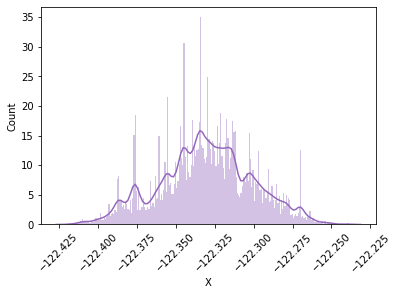

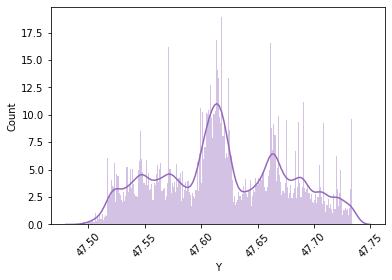

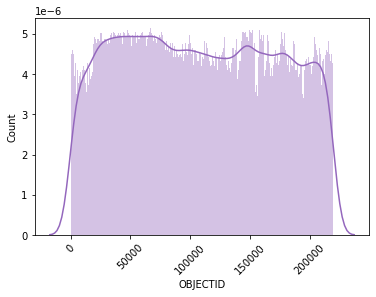

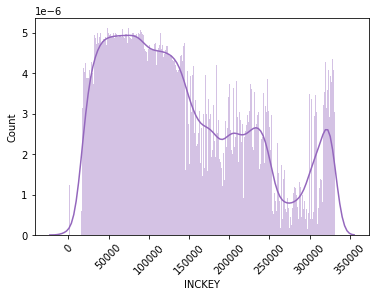

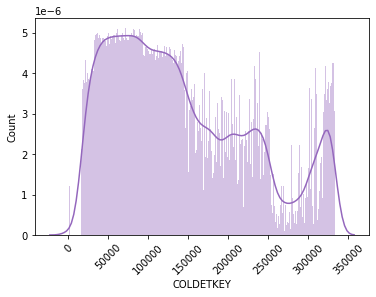

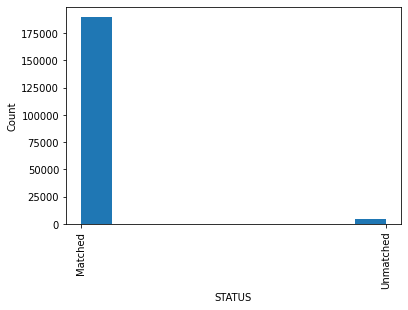

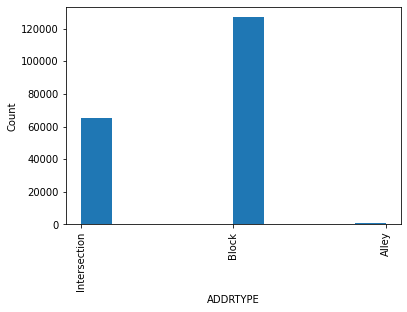

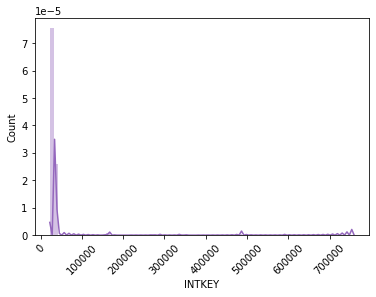

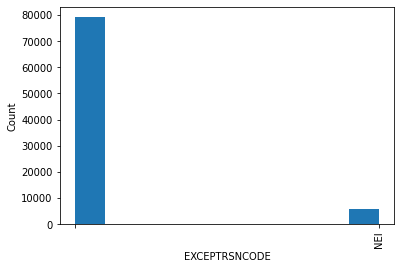

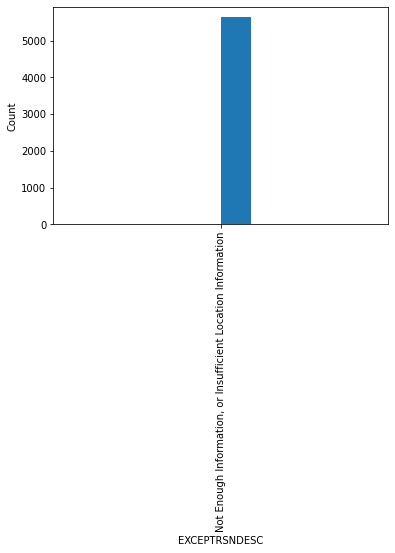

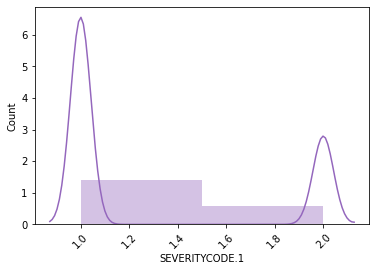

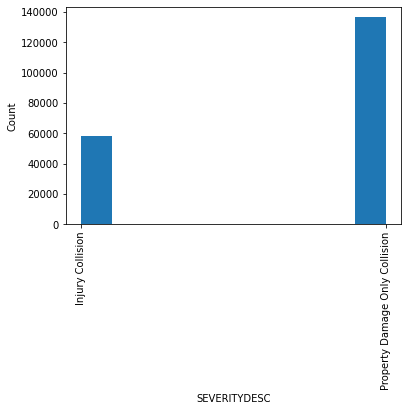

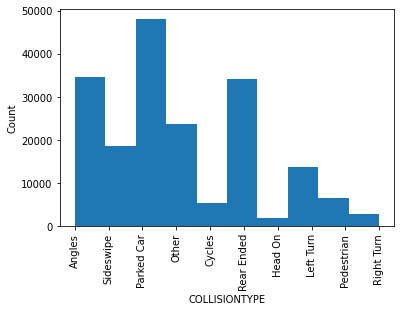

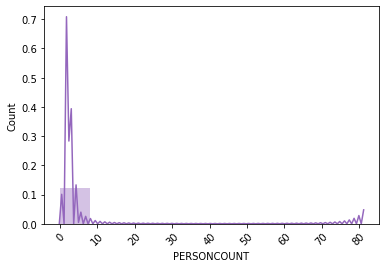

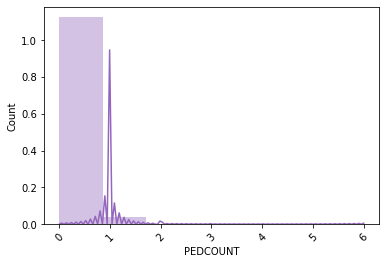

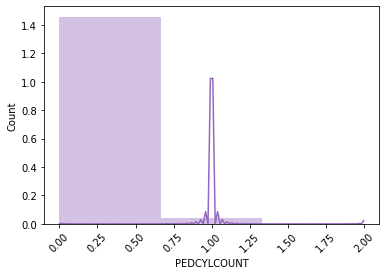

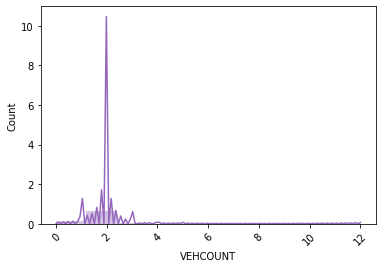

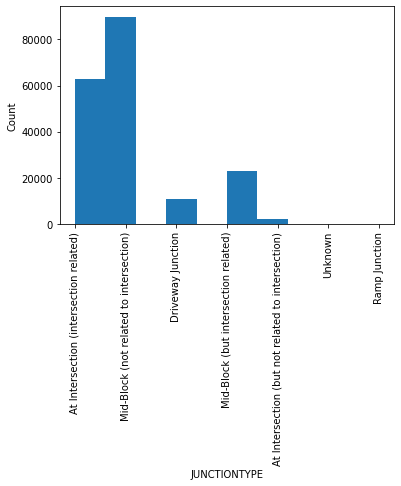

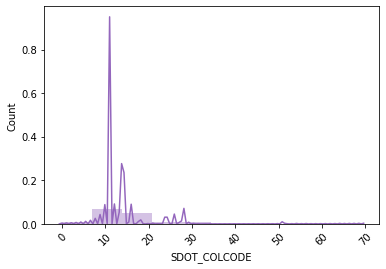

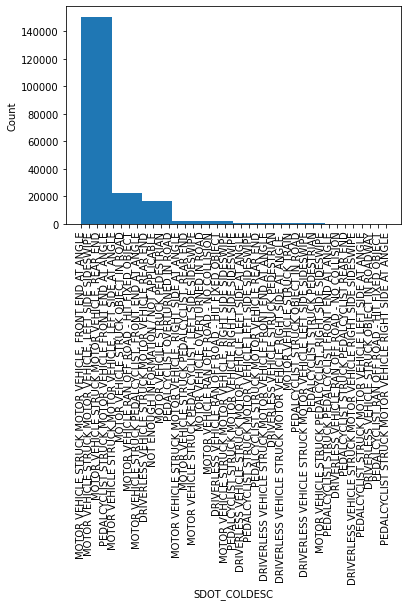

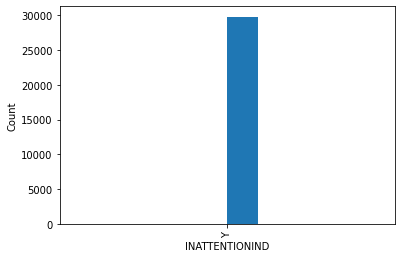

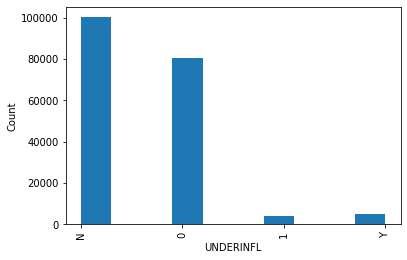

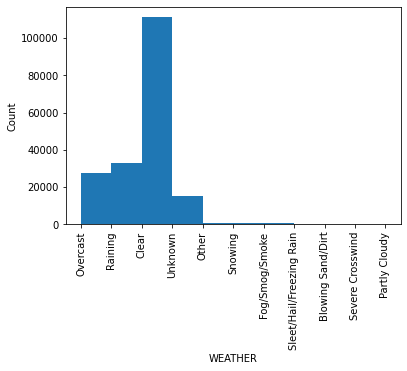

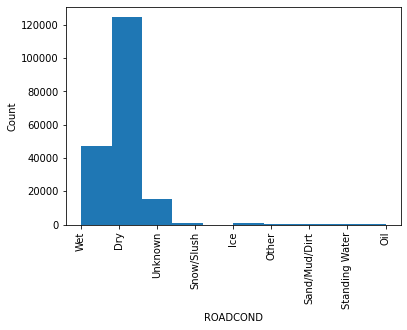

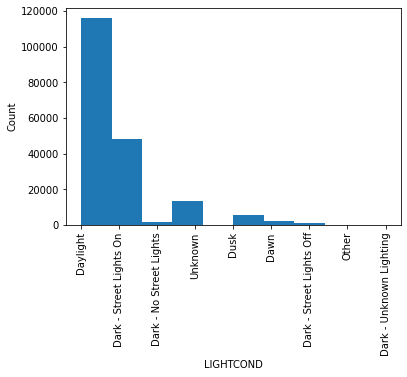

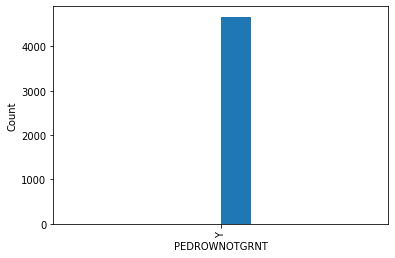

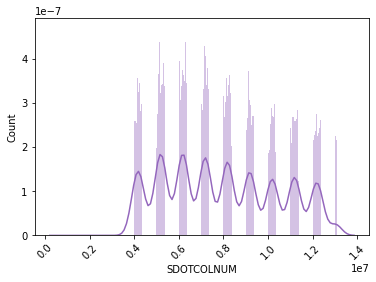

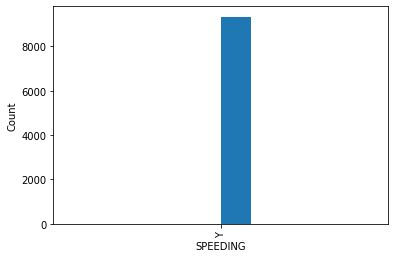

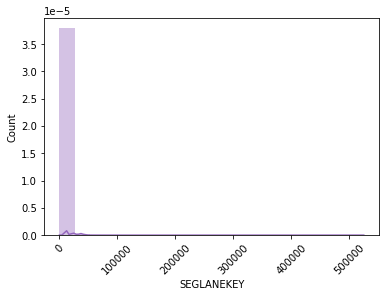

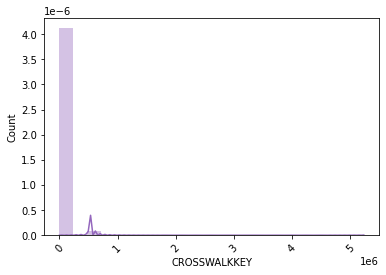

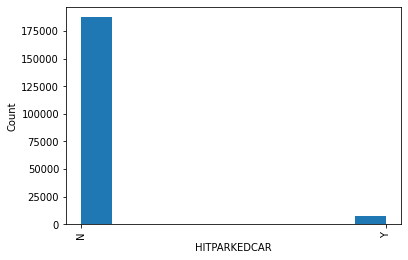

In [24]:
plotted(df,['SEVERITYCODE','REPORTNO','INCDATE','INCDTTM','LOCATION','ST_COLCODE','ST_COLDESC']).density_plt()

In [25]:
#for i in colnames:
#    print('Data Type of :', i ,'is ',df[i].dtype,' and Unique values are :',len(df[i].unique()),' and null values are :',df[i].isnull().sum())

In [26]:
#Categorical Variables with only 1 value
for i in df.columns:
  if df[df[i].notnull()][i].nunique()==1:
    print(i,df[df[i].notnull()][i].unique())

EXCEPTRSNDESC ['Not Enough Information, or Insufficient Location Information']
INATTENTIONIND ['Y']
PEDROWNOTGRNT ['Y']
SPEEDING ['Y']


In [27]:
df.groupby('SEVERITYCODE')['SPEEDING'].describe()

,count,unique,top,freq
SEVERITYCODE,,,,
1,5802,1,Y,5802
2,3531,1,Y,3531


In [28]:
df.describe()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,INTKEY,SEVERITYCODE.1,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SDOT_COLCODE,SDOTCOLNUM,SEGLANEKEY,CROSSWALKKEY
count,194673.000000,189339.000000,189339.000000,194673.000000,194673.000000,194673.000000,65070.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,1.149360e+05,194673.000000,1.946730e+05
mean,1.298901,-122.330518,47.619543,108479.364930,141091.456350,141298.811381,37558.450576,1.298901,2.444427,0.037139,0.028391,1.920780,13.867768,7.972521e+06,269.401114,9.782452e+03
std,0.457778,0.029976,0.056157,62649.722558,86634.402737,86986.542110,51745.990273,0.457778,1.345929,0.198150,0.167413,0.631047,6.868755,2.553533e+06,3315.776055,7.226926e+04
min,1.000000,-122.419091,47.495573,1.000000,1001.000000,1001.000000,23807.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.007024e+06,0.000000,0.000000e+00
25%,1.000000,-122.348673,47.575956,54267.000000,70383.000000,70383.000000,28667.000000,1.000000,2.000000,0.000000,0.000000,2.000000,11.000000,6.040015e+06,0.000000,0.000000e+00
50%,1.000000,-122.330224,47.615369,106912.000000,123363.000000,123363.000000,29973.000000,1.000000,2.000000,0.000000,0.000000,2.000000,13.000000,8.023022e+06,0.000000,0.000000e+00
75%,2.000000,-122.311937,47.663664,162272.000000,203319.000000,203459.000000,33973.000000,2.000000,3.000000,0.000000,0.000000,2.000000,14.000000,1.015501e+07,0.000000,0.000000e+00
max,2.000000,-122.238949,47.734142,219547.000000,331454.000000,332954.000000,757580.000000,2.000000,81.000000,6.000000,2.000000,12.000000,69.000000,1.307202e+07,525241.000000,5.239700e+06


###BiVariate Analysis

In [29]:
#Crosstab Categorical Variables with Target Variable
def cat_bivariate_crosstabs(x,todrop):
  df_cat = x.drop(columns=todrop)
  df_cat = df_cat.select_dtypes(include=['object','bool'])
  print(df_cat.columns)
  for col in df_cat.columns:
    print(pd.crosstab(x['SEVERITYCODE'],x[col]))

  

In [30]:
cat_bivariate_crosstabs(df,['SEVERITYCODE'])  

Index(['REPORTNO', 'STATUS', 'ADDRTYPE', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYDESC', 'COLLISIONTYPE', 'INCDATE', 'INCDTTM',
       'JUNCTIONTYPE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING',
       'ST_COLCODE', 'ST_COLDESC', 'HITPARKEDCAR'],
      dtype='object')
REPORTNO      1007488  1007489  1007491  ...  e392544  e463420  e943304
SEVERITYCODE                             ...                           
1                   0        1        1  ...        1        1        1
2                   1        0        0  ...        0        0        0

[2 rows x 194670 columns]
STATUS        Matched  Unmatched
SEVERITYCODE                    
1              132627       3858
2               57159       1029
ADDRTYPE      Alley  Block  Intersection
SEVERITYCODE                            
1               669  96830         37251
2                82  30096         27819
LOCATION      10TH AVE A

In [72]:
### remove because trivial = ['OBJECTID','REPORTNO','INCKEY','INTKEY',''COLDETKEY','SEVERITYCODE.1','LOCATION']
### remove because of very high null percentage: ['INATTENTIONIND', 'PEDROWNOTGRNT','SPEEDING',]
### remove because code exists: ['SDOT_COLDESC','SEVERITYDESC']
### remove because no information available: ['EXCEPTRSNCODE','EXCEPTRSNDESC','SEGLANEKEY',   'CROSSWALKKEY','SDOTCOLNUM']
### remove because used to create derived columns = ['INCDTTM','INCDATE']

#New Features:
# INCDTTM get time of the day (AM/PM) : TimeOfDay
#INCDATE get month of the year, day of the week (weekend/weekday) : MonthOfYear, DayOfWeek

#Missing value Treatment
#xxxxxxxreplace null with N in PEDROWNOTGRNT, SPEEDINGxxxxx
#replace N with 0 and Y with 1 in UNDERINFL 
#fill with mode in case of X,Y
#Replace NAN with Block on ADDRTYPE

#Feature Encoding
#STATUS
#ADDRTYPE
#COLLISIONTYPE

#important Features: 'HITPARKEDCAR', 'LIGHTCOND', 'ROADCOND', 'WEATHER', 'UNDERINFL', 'JUNCTIONTYPE', 'COLLISIONTYPE', 'STATUS','ADDRTYPE',ST_COLCODE

In [73]:
#Analyzing Relationship between ST_COLCODE and ST_COLDESC

In [74]:
temp1=pd.DataFrame(df.groupby('ST_COLCODE')['ST_COLDESC'].unique())
print(temp1)

                                                   ST_COLDESC
ST_COLCODE                                                   
                                                        [nan]
0                    [Vehicle going straight hits pedestrian]
1                     [Vehicle turning right hits pedestrian]
10                                        [Entering at angle]
11          [From same direction - both going straight - b...
...                                                       ...
83          [Same direction -- both turning left -- both m...
84          [Same direction -- both turning left -- one st...
85                                     [Vehicle Strikes Deer]
87            [Vehicle Strikes All Other Non-Domestic Animal]
88                                  [All Other Multi Vehicle]

[63 rows x 1 columns]


In [76]:
df[df['ST_COLDESC'].isnull()].head(2)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
15,1,-122.337663,47.617510,20,330878,332378,3838086,Unmatched,Block,NaN,9TH AVE BETWEEN LENORA ST AND BLANCHARD ST,,NaN,1,Property Damage Only Collision,NaN,1,0,0,0,2020/04/20 00:00:00+00,4/20/2020,Driveway Junction,26,MOTOR VEHICLE STRUCK OBJECT IN ROAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N
36,1,-122.335727,47.613363,45,330925,332425,3838128,Unmatched,Block,NaN,OLIVE WAY BETWEEN 6TH AVE AND 7TH AVE,,NaN,1,Property Damage Only Collision,NaN,4,0,0,0,2020/03/13 00:00:00+00,3/13/2020,Driveway Junction,11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N


In [35]:
df['ST_COLCODE'].value_counts()

32    44421
10    34674
14    25771
50    13554
11    12777
      ...  
43        2
87        2
49        1
85        1
60        1
Name: ST_COLCODE, Length: 63, dtype: int64

In [43]:
df[df['ST_COLCODE']=='32']['SEVERITYCODE'].value_counts()

1    42276
2     2145
Name: SEVERITYCODE, dtype: int64

In [132]:
#replacing ST_COLCODE missing values with the mode
df['ST_COLCODE'].dtypes

dtype('O')

In [133]:

df['ST_COLCODE'].fillna(df.ST_COLCODE.value_counts().index[0], inplace=True)
df['ST_COLCODE'].dtypes

dtype('O')

In [134]:
df.ST_COLCODE.isnull().sum()

0

In [135]:
df[df['ST_COLDESC'].isnull()]['ST_COLCODE'].isnull().sum()

0

In [136]:
#Analyzing Relationship between SDOT_COLCODE and SDOT_COLDESC

In [84]:
df.groupby('SDOT_COLCODE')['SDOT_COLDESC'].unique()

SDOT_COLCODE
0             [NOT ENOUGH INFORMATION / NOT APPLICABLE]
11    [MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END...
12    [MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SID...
13    [MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE...
14       [MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END]
15    [MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SID...
16    [MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE...
18    [MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END ...
21        [MOTOR VEHICLE STRUCK PEDALCYCLIST, REAR END]
22    [MOTOR VEHICLE STRUCK PEDALCYCLIST, RIGHT SIDE...
23    [MOTOR VEHICLE STRUCK PEDALCYCLIST, LEFT SIDE ...
24                    [MOTOR VEHCILE STRUCK PEDESTRIAN]
25                         [MOTOR VEHICLE STRUCK TRAIN]
26                [MOTOR VEHICLE STRUCK OBJECT IN ROAD]
27          [MOTOR VEHICLE RAN OFF ROAD - NO COLLISION]
28      [MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT]
29                   [MOTOR VEHICLE OVERTURNED IN ROAD]
31    [DRIVERLESS VEHICLE STRUCK MO

In [85]:
#No Missing values. can drop SDOT_COLDESC

In [87]:
#Remove because no information available
df['SDOTCOLNUM'].head()

0          NaN
1    6354039.0
2    4323031.0
3          NaN
4    4028032.0
Name: SDOTCOLNUM, dtype: float64

In [137]:
df['MonthOfYear'] = pd.to_datetime(df['INCDATE']).dt.month
df['DayOfWeek'] = pd.to_datetime(df['INCDATE']).dt.weekday
df['TimeOfDay'] = pd.to_datetime(df['INCDTTM']).dt.hour
df[['MonthOfYear','DayOfWeek','TimeOfDay']].head()

,MonthOfYear,DayOfWeek,TimeOfDay
0,3,2,14
1,12,2,18
2,11,3,10
3,3,4,9
4,1,2,8


In [89]:
df.columns.to_list()

['SEVERITYCODE',
 'X',
 'Y',
 'OBJECTID',
 'INCKEY',
 'COLDETKEY',
 'REPORTNO',
 'STATUS',
 'ADDRTYPE',
 'INTKEY',
 'LOCATION',
 'EXCEPTRSNCODE',
 'EXCEPTRSNDESC',
 'SEVERITYCODE.1',
 'SEVERITYDESC',
 'COLLISIONTYPE',
 'PERSONCOUNT',
 'PEDCOUNT',
 'PEDCYLCOUNT',
 'VEHCOUNT',
 'INCDATE',
 'INCDTTM',
 'JUNCTIONTYPE',
 'SDOT_COLCODE',
 'SDOT_COLDESC',
 'INATTENTIONIND',
 'UNDERINFL',
 'WEATHER',
 'ROADCOND',
 'LIGHTCOND',
 'PEDROWNOTGRNT',
 'SDOTCOLNUM',
 'SPEEDING',
 'ST_COLCODE',
 'ST_COLDESC',
 'SEGLANEKEY',
 'CROSSWALKKEY',
 'HITPARKEDCAR',
 'MonthOfYear',
 'DayOfWeek',
 'TimeOfDay']

In [138]:
#UNDERINFL treatment
df['UNDERINFL'].replace(to_replace=['N','Y'],value=['0','1'], inplace=True)

In [91]:
pd.crosstab(df['SEVERITYCODE'],df['UNDERINFL'])

UNDERINFL,0,1
SEVERITYCODE,,
1,127071,5559
2,53597,3562


In [93]:
df[df['UNDERINFL'].isnull()]['SEVERITYCODE'].value_counts()

1    3855
2    1029
Name: SEVERITYCODE, dtype: int64

In [139]:
#filling missing values with 0 in UNDERINFL
df['UNDERINFL'].fillna(0, inplace=True)

In [140]:
df['UNDERINFL'].replace(0,'0', inplace=True)

In [141]:
pd.crosstab(df['SEVERITYCODE'],df['UNDERINFL'])

UNDERINFL,0,1
SEVERITYCODE,,
1,130926,5559
2,54626,3562


In [99]:
df[df['SPEEDING']!='Y'].head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,MonthOfYear,DayOfWeek,TimeOfDay
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N,3,2,14
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N,12,2,18
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N,11,3,10
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N,3,4,9
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N,1,2,8


In [100]:
df['SPEEDING'].isnull().sum()/df.shape[0]
#very high missing percentage: remove column

0.9520580666039975

In [106]:
#location has over 20000 categories. No significant information gain, can remove.
df['LOCATION'].head()

0                     5TH AVE NE AND NE 103RD ST
1     AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N
2    4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST
3       2ND AVE BETWEEN MARION ST AND MADISON ST
4                SWIFT AVE S AND SWIFT AV OFF RP
Name: LOCATION, dtype: object

In [142]:
df['X'].dtype

dtype('float64')

In [143]:
#Missing Value treatment for X,Y
df.X.fillna(df.X.mean(), inplace=True)
df.Y.fillna(df.Y.mean(),inplace=True)
df[['X','Y']].isnull().sum()

X    0
Y    0
dtype: int64

In [144]:
df['X'].dtype

dtype('float64')

In [109]:
df[['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','ST_COLCODE']].isnull().sum()

ADDRTYPE         1926
COLLISIONTYPE    4904
JUNCTIONTYPE     6329
UNDERINFL           0
WEATHER          5081
ROADCOND         5012
LIGHTCOND        5170
ST_COLCODE          0
dtype: int64

In [110]:
for col in ['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND']:
  print(df[col].value_counts())
  print('null value count', df[[col]].isnull().sum())

Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64
null value count ADDRTYPE    1926
dtype: int64
Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64
null value count COLLISIONTYPE    4904
dtype: int64
Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64
null value count JUNCTIONTYPE    6329
dtype: int64
Clear                       111135
Raining                      33145
Ov

In [145]:
#updating missing values as modes of the above respoective variables
for col in ['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND']:
  df[col].fillna(df[col].value_counts().index[0], inplace=True)
  print('null value count', df[[col]].isnull().sum())

null value count ADDRTYPE    0
dtype: int64
null value count COLLISIONTYPE    0
dtype: int64
null value count JUNCTIONTYPE    0
dtype: int64
null value count WEATHER    0
dtype: int64
null value count ROADCOND    0
dtype: int64
null value count LIGHTCOND    0
dtype: int64


In [146]:
df['HITPARKEDCAR'].value_counts()

N    187457
Y      7216
Name: HITPARKEDCAR, dtype: int64

In [114]:
df['HITPARKEDCAR'].isnull().sum()

0

In [113]:
df['STATUS'].value_counts()

Matched      189786
Unmatched      4887
Name: STATUS, dtype: int64

In [115]:
df['STATUS'].isnull().sum()

0

###Feature Selection and creating Select Column dataset

In [147]:
dfs = df[['SEVERITYCODE','X','Y','STATUS','ADDRTYPE','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','JUNCTIONTYPE','SDOT_COLCODE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','ST_COLCODE','HITPARKEDCAR','MonthOfYear','DayOfWeek','TimeOfDay']]

In [148]:
dfs.shape

(194673, 21)

In [149]:
dfs.isnull().sum()

SEVERITYCODE     0
X                0
Y                0
STATUS           0
ADDRTYPE         0
COLLISIONTYPE    0
PERSONCOUNT      0
PEDCOUNT         0
PEDCYLCOUNT      0
VEHCOUNT         0
JUNCTIONTYPE     0
SDOT_COLCODE     0
UNDERINFL        0
WEATHER          0
ROADCOND         0
LIGHTCOND        0
ST_COLCODE       0
HITPARKEDCAR     0
MonthOfYear      0
DayOfWeek        0
TimeOfDay        0
dtype: int64

In [150]:
dfs.dtypes

SEVERITYCODE       int64
X                float64
Y                float64
STATUS            object
ADDRTYPE          object
COLLISIONTYPE     object
PERSONCOUNT        int64
PEDCOUNT           int64
PEDCYLCOUNT        int64
VEHCOUNT           int64
JUNCTIONTYPE      object
SDOT_COLCODE       int64
UNDERINFL         object
WEATHER           object
ROADCOND          object
LIGHTCOND         object
ST_COLCODE        object
HITPARKEDCAR      object
MonthOfYear        int64
DayOfWeek          int64
TimeOfDay          int64
dtype: object

In [151]:
#Perform encoding on Categorical variables

In [153]:
dfs.select_dtypes(include='object').columns

Index(['STATUS', 'ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'ST_COLCODE', 'HITPARKEDCAR'],
      dtype='object')

In [154]:
dfs.select_dtypes(include='number').columns

Index(['SEVERITYCODE', 'X', 'Y', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT',
       'VEHCOUNT', 'SDOT_COLCODE', 'MonthOfYear', 'DayOfWeek', 'TimeOfDay'],
      dtype='object')

### information about variables to create model

In [ ]:
#From these important Features, some of the features are post facto and not related to 

In [ ]:
dfs = df.sample(frac=0.1, random_state=111)
dfs.shape

In [ ]:
fig = plt.figure(figsize=(20,20))

plt.scatter(dfs[])

plt.show()

In [ ]:
dfs.hist(figsize=(20,20))
plt.show()

In [ ]:
cor = dfs.corr()
plt.figure(figsize=(12,8))
sns.heatmap(cor)
plt.show()

In [ ]:
df['SEVERITYCODE'].value_counts()

In [ ]:
df['X'].value_counts()

In [ ]:
sns.scatterplot(dfs['X'],dfs['Y'],hue=dfs['SEVERITYCODE'])
plt.show()

In [ ]:
df['X'].fillna(df['X'].mean(), inplace=True)
df['Y'].fillna(df['Y'].mean(), inplace=True)


In [ ]:
keep = ['']
